In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import signal


In [2]:
photodiode_data = pd.read_csv('photodiode_test.csv')
photodiode_data = photodiode_data.iloc[::10, :]
photodiode_bool = photodiode_data > np.mean(photodiode_data)
task_events = pd.read_csv('../logger/aDBS009/logger_31-08-2023_13:05:00.702599_v1.0.0.csv')
datetime_objects = [datetime.strptime(i, '%d-%m-%Y %H:%M:%S.%f') for i in task_events['timestamp']] 
task_events.insert(1, "datetime", datetime_objects, True)
print(photodiode_data)
task_events

         399
0        400
10       400
20       400
30       400
40       400
...      ...
5116300  114
5116310  114
5116320  114
5116330  114
5116340  114

[511635 rows x 1 columns]


,timestamp,datetime,subject,block_type,block,trial,state,event,extra_comments
0,31-08-2023 13:05:01.915154,2023-08-31 13:05:01.915154,aDBS009,conflict,1,1,start,0,Start Block (Pressed Spacebar)
1,31-08-2023 13:05:01.924609,2023-08-31 13:05:01.924609,aDBS009,conflict,1,1,start,2,Start Trial Fix Gaze (Begin)
2,31-08-2023 13:05:02.755555,2023-08-31 13:05:02.755555,aDBS009,conflict,1,1,start,3,Start Trial Fix Gaze (End)
3,31-08-2023 13:05:02.762815,2023-08-31 13:05:02.762815,aDBS009,conflict,1,1,start,4,Display Trial Options
4,31-08-2023 13:05:03.779847,2023-08-31 13:05:03.779847,aDBS009,conflict,1,1,start,1,Select option 1 (Circle)
...,...,...,...,...,...,...,...,...,...
118,31-08-2023 13:06:17.037055,2023-08-31 13:06:17.037055,aDBS009,congruent,2,5,start,7,phaelb/Documents/UW/Research/gridlab/adbs_ocd/...
119,31-08-2023 13:06:18.551653,2023-08-31 13:06:18.551653,aDBS009,congruent,2,5,start,8,End Stimulus
120,31-08-2023 13:06:18.567116,2023-08-31 13:06:18.567116,aDBS009,congruent,2,5,start,9,Reward Anticipation Fix Gaze (Start)
121,31-08-2023 13:06:19.852075,2023-08-31 13:06:19.852075,aDBS009,congruent,2,5,start,10,Reward Anticipation Fix Gaze (End)


511635


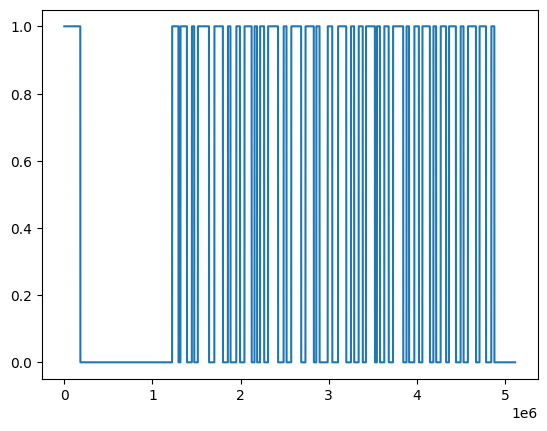

In [13]:
print(len(photodiode_bool))
# plt.plot(np.diff(photodiode_data.iloc[:,0]))#
plt.plot(photodiode_bool)
# plt.plot(~event_bools*.75)
# plt.xlim([1e6,2e6])


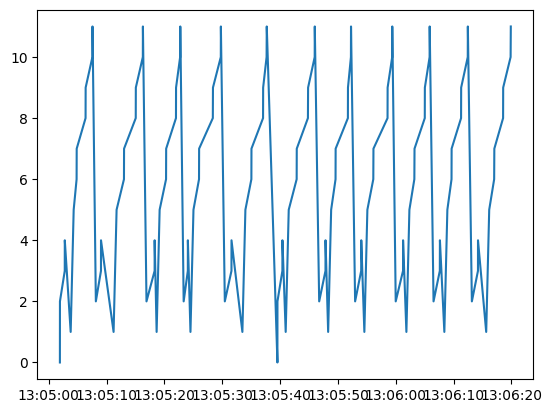

In [4]:
plt.plot(task_events['datetime'],task_events['event'])

In [14]:
task_duration = (task_events['datetime'].iloc[-1]-task_events['datetime'].iloc[0]).total_seconds()
print('Task Log Duration = ',task_duration, 'seconds')
phototiode_task_estimated_fs = (4.8796e5-1.22334e5)/task_duration
print('Calculated Photodiode Data fs = ',phototiode_task_estimated_fs, 'Hz')
photodiode_total_duration = len(photodiode_bool) / phototiode_task_estimated_fs
print('photodiode data duration = ', photodiode_total_duration, 'seconds')
photodiode_start_time = task_events['datetime'].iloc[0] - timedelta(seconds=1.22334e5 / phototiode_task_estimated_fs)

Task Log Duration =  77.969388 seconds
Calculated Photodiode Data fs =  4689.353211288512 Hz
photodiode data duration =  109.10566488537468 seconds


In [15]:
t = pd.date_range(start=photodiode_start_time,end=photodiode_start_time+timedelta(seconds=photodiode_total_duration),periods=len(photodiode_bool))
photodiode_timestamps = t.values
event_bools = np.zeros(len(photodiode_timestamps),dtype=bool).reshape(-1,1)
alignment_events = task_events.loc[task_events['event'].isin([2,3,5,6,9,10])]

event_count = 1
is_event = False
for i in range(len(event_bools)):
    if event_count<len(alignment_events) and photodiode_timestamps[i] >= alignment_events['datetime'].iloc[event_count]:
        is_event = not is_event
        event_count = event_count + 1
    event_bools[i] = is_event


(19600.54515529492, 19600.546093197558)

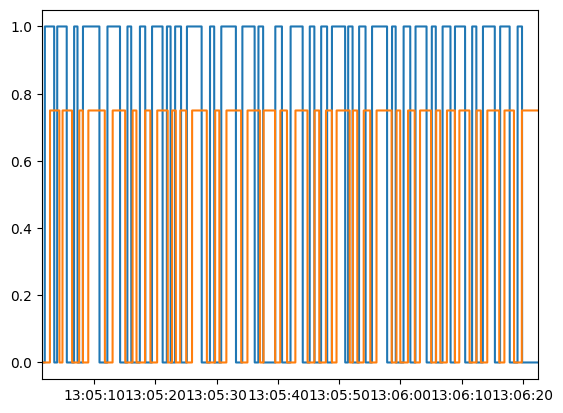

In [69]:
plt.plot(photodiode_timestamps,photodiode_bool)
plt.plot(photodiode_timestamps,event_bools*.75)
plt.xlim([photodiode_timestamps[int(1.2e5)],photodiode_timestamps[int(5e5)]])


In [60]:
photodiode_bool = np.array(photodiode_bool,dtype=int)
event_bools = np.array(event_bools,dtype=int)
correlation = signal.correlate(photodiode_bool,event_bools)
# plt.plot(correlation)
shift = np.argmax(correlation) - len(photodiode_bool)
print(shift)
micro_shift = int(shift/phototiode_task_estimated_fs *1e6)
aligned_events_timestmap = photodiode_timestamps + np.timedelta64(micro_shift,'us')


-3861


(19600.54515529492, 19600.545846381076)

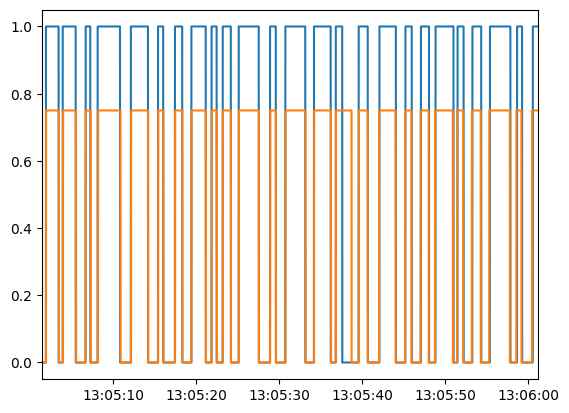

In [70]:
plt.plot(photodiode_timestamps,photodiode_bool)
plt.plot(aligned_events_timestmap,event_bools*.75)
plt.xlim([photodiode_timestamps[int(1.2e5)],photodiode_timestamps[int(4e5)]])


array(['2023-08-31T13:04:35.827548000', '2023-08-31T13:04:35.827761249',
       '2023-08-31T13:04:35.827974498', ...,
       '2023-08-31T13:06:24.932786501', '2023-08-31T13:06:24.932999750',
       '2023-08-31T13:06:24.933213000'], dtype='datetime64[ns]')